# AlexNet model training Notebook

 ## Data Preprocessing

In [15]:
"""
Import Libraries and Set Random Seed
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, random_split
import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

#define pytorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_per_process_memory_fraction(0.5, 0)


SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [16]:
"""
Use pipeline detailed in data_prep_training.py to import the dataloaders for model training:
"""
from data_prep_training import get_dataloaders

path = '../../data/preprocessed_renamed'

train_loader, val_loader, test_loader = get_dataloaders(path, batch_size=100, img_size=(100, 100), train_ratio=0.8, val_ratio=0.05)


In [17]:
torch.save(train_loader, './output/train_loader.pth')

torch.save(val_loader, './output/val_loader.pth')

torch.save(test_loader, './output/test_loader.pth')

# train_loader = torch.load('./output/train_loader.pth')
# val_loader = torch.load('./output/val_loader.pth')
# test_loader = torch.load('./output/test_loader.pth')

 ## Defining a Convolutional Neural Network

In [18]:
"""
Load pretrained AlexNet model that will be fine-tuned with the MRI dataset.
MRI dataset has 5 classes of Lumbar Spine Degenerative Conditions.
"""

#init a pretrained AlexNet model from Pytorch, edit the last classifier layer to output 5 classes
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2) #this is to allow for our images to fit (100x100)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5) #change to 5 outputs for the 5 classes
model = model.to(device)


 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

In [19]:
def eval_or_train(model, dataloader, optimizer, criterion, device, mode = 'eval'):
    if mode == 'train':
        #init training mode
        model.train()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            
            optimizer.zero_grad()
            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #backprop
            curr_loss.backward()
            #gradient descent step
            optimizer.step()

            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        

        train_avg_loss = epoch_total_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        return train_avg_loss, train_acc
    
    elif mode == 'eval':
        #init eval mode
        model.eval()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []


        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #add to running loss and get prediction
            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            #get the number of correct preds and total preds
            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        eval_avg_loss = epoch_total_loss / len(train_loader.dataset)
        eval_acc = accuracy_score(all_labels, all_preds)
        

        return eval_avg_loss, eval_acc


In [20]:
"""
Init parameters, optimizer, loss function, lr-scheduler, 
"""

# define model parameters
NUM_EPOCHS = 40
NUM_CLASSES = 5

#define optimizer and loss functions
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))



In [21]:
"""
Run epochs
"""
#init loss lists
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

#for checkpointing later
best_val_accuracy = 0  
output_folder = "./output/"



for e in range(1, NUM_EPOCHS+1):

    train_loss, train_acc = eval_or_train(model, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    test_loss, test_acc = eval_or_train(model, test_loader, optimizer, criterion, device, mode = 'eval')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), os.path.join(output_folder, f'alexnet_project_best_shawn.pth'))


    print("Epoch number:", e, "/", NUM_EPOCHS)
    print("      Train acc -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation acc -- ", val_acc, "; Validation loss -- ", val_loss)
    print("      Test acc -- ", test_acc, "; Test loss -- ", test_loss)

Epoch number: 1 / 40
      Train acc --  0.7867888683507908 ; Train loss --  0.3649514742558265
      Validation acc --  0.8274445357436319 ; Validation loss --  0.017834025244065
      Test acc --  0.8083504449007529 ; Test loss --  0.059444648687092524


KeyboardInterrupt: 

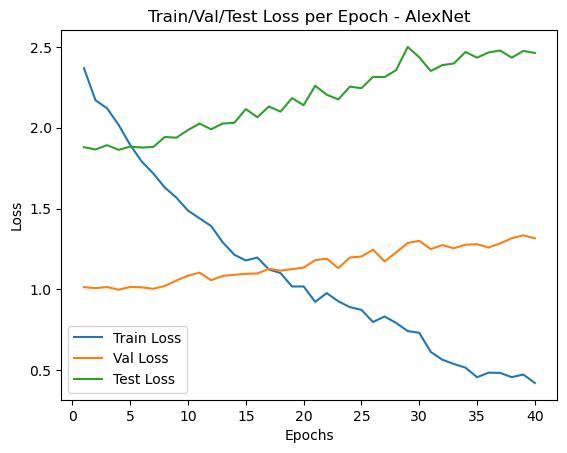

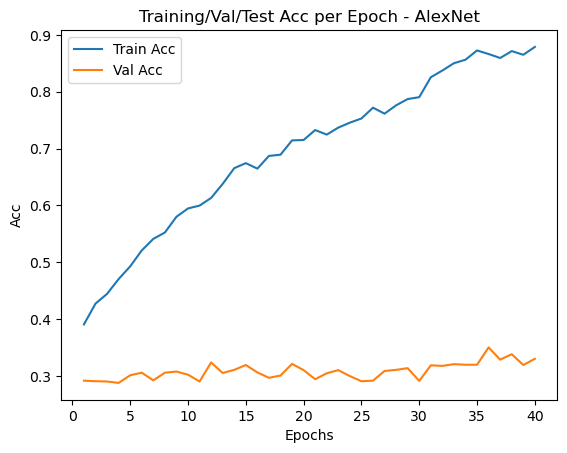

In [41]:
"""
Display losses and accuracy:
"""

fig = plt.figure()
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_loss_list, label = 'Val Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), test_loss_list, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val/Test Loss per Epoch - AlexNet')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_acc_list, label = 'Train Acc')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_acc_list, label = 'Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Training/Val/Test Acc per Epoch - AlexNet')
plt.legend()
plt.show()

__Observations:__

There is very clearly some overfitting going on. Will do again with some changes.

 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
    - Prof. Nakul said we don't need to achieve this accuracy but to try to fine-tune through eliminating the image transformations when importing to images


In [23]:
"""
Reimport dataset with tuned transformations:
"""

#define the transform function as seen in lab-07b video
transform = transforms.Compose([
    transforms.Resize((224,224), Image.BILINEAR),
    # transforms.RandomCrop((112,112)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize using the parameters normally 
                                                                       #used in many computer vision practices
])


#now load in train and test sets for the Cub dataset
train = Cub2011(root = './', train = True, transform = transform, download = True)
test = Cub2011(root = './', train = False, transform = transform, download = True)

#split test for validation dataset
new_test, new_val = random_split(test, [len(test) - 2000, 2000])

#make DataLoaders for the train and test datasets
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
val_loader = DataLoader(new_val, batch_size = 64, shuffle = True)
test_loader = DataLoader(new_test, batch_size = 64, shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [60]:
"""
Reinit model and other parameters:
"""

model2 = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, 200) #change to 200 number of classes output for 200 classes in CUB-200-2011 dataset
model2 = model2.to(device)

# define model parameters
NUM_EPOCHS = 40  # original paper
LR_INIT = 0.01
NUM_CLASSES = 200 #CUB-200-2011 dataset

#define optimizer and loss functions
optimizer = optim.Adam(params=model2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))

In [61]:
"""
Redo epochs on new dataset and model again:
"""

#init loss lists
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

#for checkpointing later
best_val_accuracy = 0  
output_folder = "./output/"



for e in range(1, NUM_EPOCHS+1):

    train_loss, train_acc = eval_or_train(model2, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = eval_or_train(model2, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    test_loss, test_acc = eval_or_train(model2, test_loader, optimizer, criterion, device, mode = 'eval')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model2.state_dict(), os.path.join(output_folder, f'alexnet_lab7_best2.pth'))


    print("Epoch number:", e, "/", NUM_EPOCHS)
    print("      Train acc -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation acc -- ", val_acc, "; Validation loss -- ", val_loss)
    print("      Test acc -- ", test_acc, "; Test loss -- ", test_loss)

Epoch number: 1 / 40
      Train acc --  0.11578244911578245 ; Train loss --  4.254475689029789
      Validation acc --  0.295 ; Validation loss --  0.9558750747003514
      Test acc --  0.3173431734317343 ; Test loss --  1.7409703731536865
Epoch number: 2 / 40
      Train acc --  0.4731398064731398 ; Train loss --  1.9633003537321552
      Validation acc --  0.391 ; Validation loss --  0.7732480150642178
      Test acc --  0.42540853979968374 ; Test loss --  1.3940116153942332
Epoch number: 3 / 40
      Train acc --  0.6975308641975309 ; Train loss --  1.0460815654224183
      Validation acc --  0.424 ; Validation loss --  0.7821123551479132
      Test acc --  0.4399051133368477 ; Test loss --  1.4003238739233872
Epoch number: 4 / 40
      Train acc --  0.8333333333333334 ; Train loss --  0.5647749940196315
      Validation acc --  0.4435 ; Validation loss --  0.842562039374987
      Test acc --  0.4620453347390617 ; Test loss --  1.4836408233578937
Epoch number: 5 / 40
      Train ac

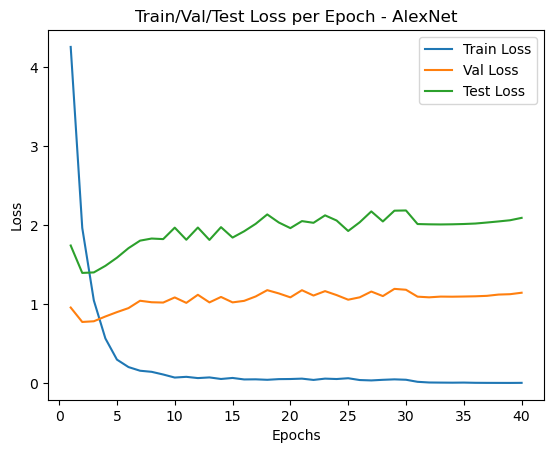

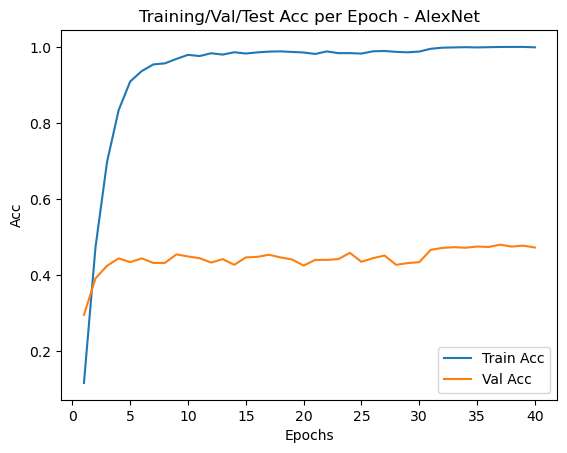

In [62]:
"""
Display losses and accuracy again:
"""

fig = plt.figure()
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_loss_list, label = 'Train Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_loss_list, label = 'Val Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), test_loss_list, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val/Test Loss per Epoch - AlexNet')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_acc_list, label = 'Train Acc')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_acc_list, label = 'Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Training/Val/Test Acc per Epoch - AlexNet')
plt.legend()
plt.show()

__Observations:__

There is much more obvious dip for validation and testing losses but it seems overfitting or stagnating is still occurring as the epochs keep running. 

 ### Viewing our model's mistakes


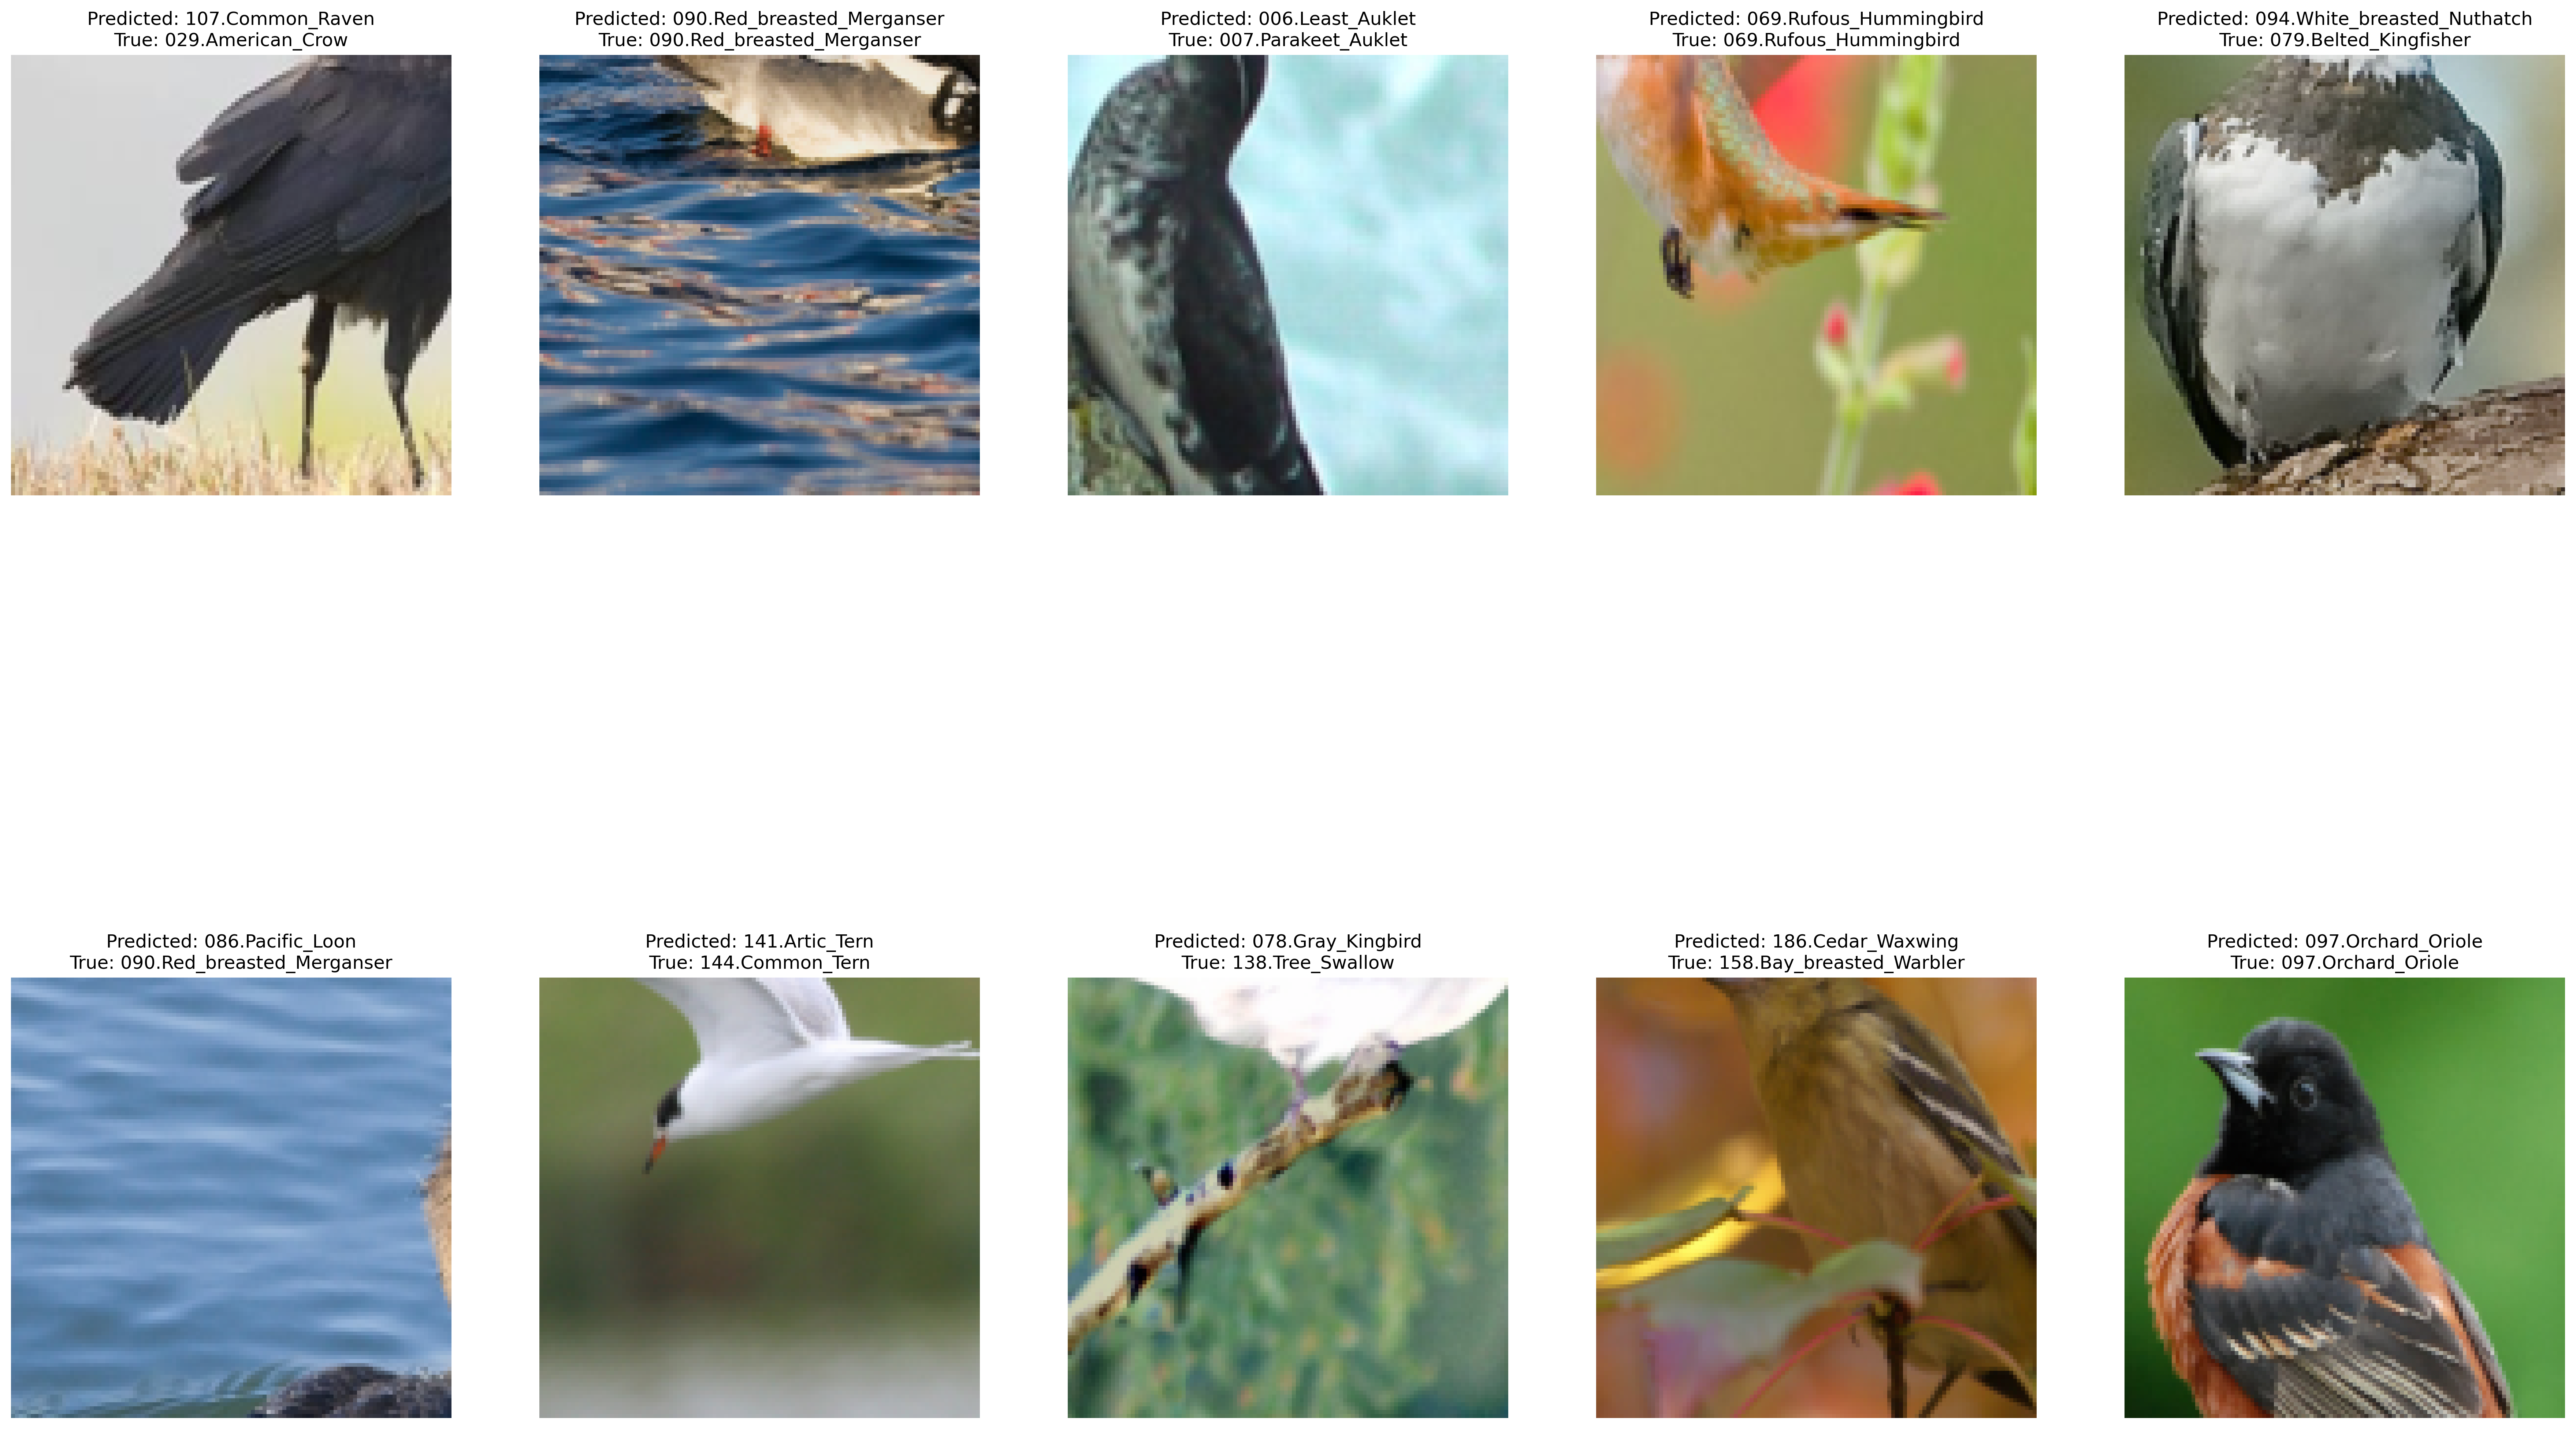

In [22]:
"""
Code from Vision_mnasnet1_3.ipynb to view the model performance and its mistakes.
Reload the model that I trained the day before.
Viewing the performance of the FIRST model on the validation data here:
"""
#reload the FIRST trained model:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 200) #change to 200 number of classes output for 200 classes in CUB-200-2011 dataset
model = model.to(device)
model.load_state_dict(torch.load('output/alexnet_lab7_best.pth'))


# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(new_val)), 10)
images, true_labels = zip(*[new_val[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = test.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {test.classes[true_label]}')
    plt.axis('off')
plt.show()

__Observations:__

It looks like about 7 out of 10 birds were wrongly identified which is close to the accuracy we got from the validation and test datasets during training and evaluation phase. It seems the image transformations like random cropping and random horizontal flipping might've caused errors in identification of birds as some pictures shown above don't even appear in the image being fed into AlexnNet. That is why to fine-tune the model training, I have decided to remove the random cropping and random flipping for training again.

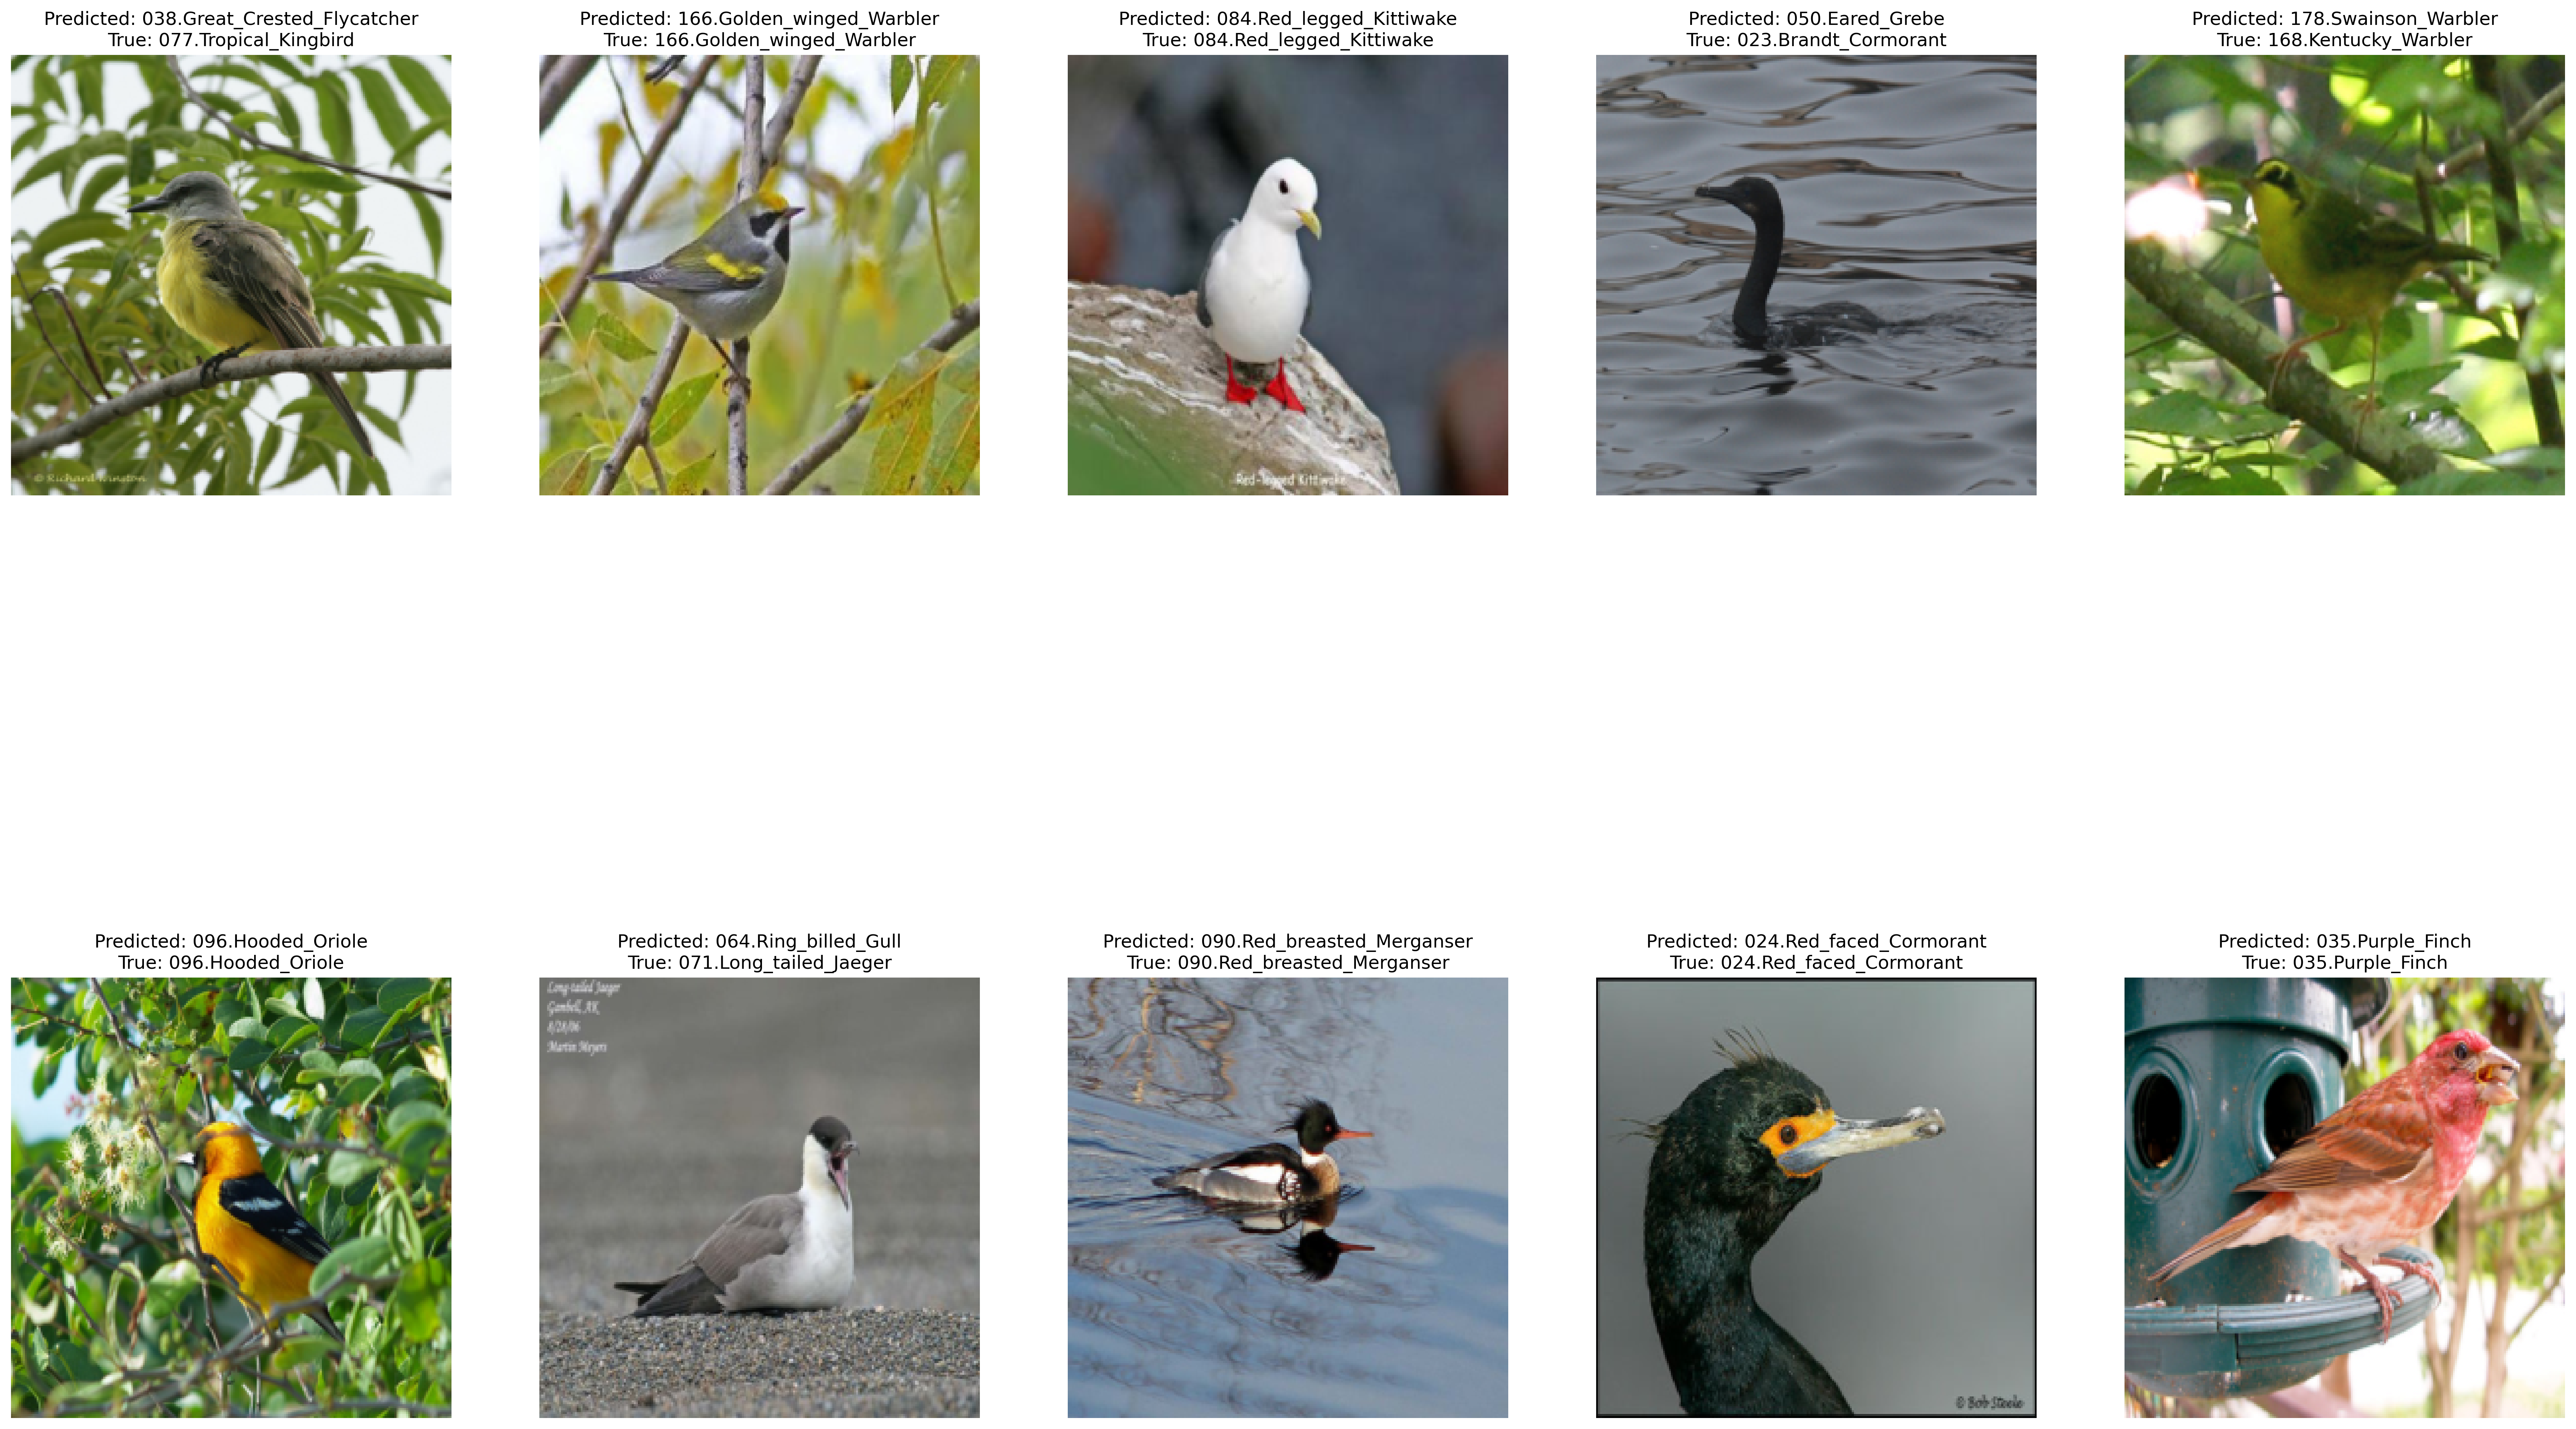

In [26]:
"""
Same plotting code as before ^.

Viewing the performance of the SECOND model on the validation data here:
"""
#reload the SECOND trained model:
model2 = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, 200) #change to 200 number of classes output for 200 classes in CUB-200-2011 dataset
model2 = model2.to(device)
model2.load_state_dict(torch.load('output/alexnet_lab7_best2.pth'))


# Set the model to evaluation mode
model2.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(new_val)), 10)
images, true_labels = zip(*[new_val[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = test.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {test.classes[true_label]}')
    plt.axis('off')
plt.show()

__Observations:__

In this second model results showcase, 4 out of the 10 images were incorrectly identified which shows a stronger performance in the second model. And in general, there are a lot more instances of higher accuracy performances after removing the random transformation methods and it shows in the second model's accuracy and loss performance evaluation plots.

 ### Viewing the learned weights of our model

In [28]:
"""
Show the second model's learned weights:
"""

for name, param in model2.named_parameters():
    print(f"{name}: {param}")

features.0.weight: Parameter containing:
tensor([[[[ 1.1689e-01,  9.2940e-02,  9.3292e-02,  ...,  5.4904e-02,
            2.1047e-02,  4.9796e-02],
          [ 7.2802e-02,  3.7876e-02,  5.1677e-02,  ...,  2.4003e-02,
           -1.1234e-02,  5.6729e-03],
          [ 7.2332e-02,  3.6460e-02,  5.3345e-02,  ...,  4.2280e-02,
            1.0813e-02,  1.5146e-02],
          ...,
          [ 9.1952e-02,  1.0361e-01,  6.8253e-02,  ..., -2.0209e-01,
           -1.2617e-01, -1.1072e-01],
          [ 3.9351e-02,  6.2770e-02,  3.4802e-02,  ..., -2.0242e-01,
           -1.1350e-01, -1.0702e-01],
          [ 4.2486e-02,  5.8341e-02,  2.1528e-02,  ..., -1.1993e-01,
           -9.7245e-02, -8.6770e-02]],

         [[-7.3797e-02, -5.8835e-02, -8.2153e-02,  ..., -9.3564e-05,
           -2.3730e-02,  2.8264e-02],
          [-7.0742e-02, -6.8196e-02, -7.7262e-02,  ..., -4.0057e-03,
           -2.7799e-02,  1.5211e-02],
          [-1.0245e-01, -8.7764e-02, -1.0661e-01,  ..., -2.6162e-02,
           -1.938